In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, auc, precision_recall_curve,
                             average_precision_score)

import shap

plt.style.use('fivethirtyeight')
sns.set_palette("Set2")

In [11]:
df = pd.read_excel('default of credit card clients.xls', header=1)

print("Data Shape:", df.shape)
print("\nFirst few rows of data:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nColumn Names:")
print(df.columns.tolist())

target_col = df.columns[-1]
print(f"\nTarget variable: {target_col}")
print("Target Variable Distribution:")
default_counts = df[target_col].value_counts()
print(default_counts)
print(f"Default Rate: {default_counts[1] / len(df) * 100:.2f}%")

missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)

print("\nColumns with missing values:")
print(missing_df)


Data Shape: (30000, 25)

First few rows of data:
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  defa

In [17]:
data = df.copy()

print(f"Using '{target_col}' as target variable")
print(f"Default rate: {data[target_col].mean():.4f}")

categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

categorical_cols = [col for col in categorical_cols if col in data.columns]

numerical_cols = [col for col in data.columns if col not in categorical_cols + [target_col, 'ID']]
if 'ID' in data.columns:
    data = data.drop('ID', axis=1)  # Remove ID column

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

Using 'default payment next month' as target variable
Default rate: 0.2212
Categorical columns: ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
Numerical columns: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [19]:
pay_columns = [f'PAY_{i}' for i in range(0, 7) if f'PAY_{i}' in data.columns]
if pay_columns:
    data['Avg_Payment_Delay'] = data[pay_columns].mean(axis=1)
    data['Max_Payment_Delay'] = data[pay_columns].max(axis=1)
    data['Payment_Problems_Count'] = (data[pay_columns] > 0).sum(axis=1)
    numerical_cols.extend(['Avg_Payment_Delay', 'Max_Payment_Delay', 'Payment_Problems_Count'])

if 'BILL_AMT1' in data.columns and 'PAY_AMT1' in data.columns:
    data['Bill_to_Payment_Ratio'] = data['PAY_AMT1'] / (data['BILL_AMT1'] + 1)  # +1 to avoid division by zero
    numerical_cols.append('Bill_to_Payment_Ratio')

bill_columns = [f'BILL_AMT{i}' for i in range(1, 7) if f'BILL_AMT{i}' in data.columns]
if bill_columns and 'LIMIT_BAL' in data.columns:
    data['Avg_Bill_Amount'] = data[bill_columns].mean(axis=1)
    data['Credit_Utilization'] = data['Avg_Bill_Amount'] / data['LIMIT_BAL']
    numerical_cols.extend(['Avg_Bill_Amount', 'Credit_Utilization'])

if 'AGE' in data.columns:
    data['Young_Adult'] = (data['AGE'] < 30).astype(int)
    data['Middle_Aged'] = ((data['AGE'] >= 30) & (data['AGE'] <= 50)).astype(int)
    data['Senior'] = (data['AGE'] > 50).astype(int)
    numerical_cols.extend(['Young_Adult', 'Middle_Aged', 'Senior'])

X = data.drop(target_col, axis=1)
y = data[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Default rate: {y.mean():.4f}")

Features shape: (30000, 32)
Target shape: (30000,)
Default rate: 0.2212


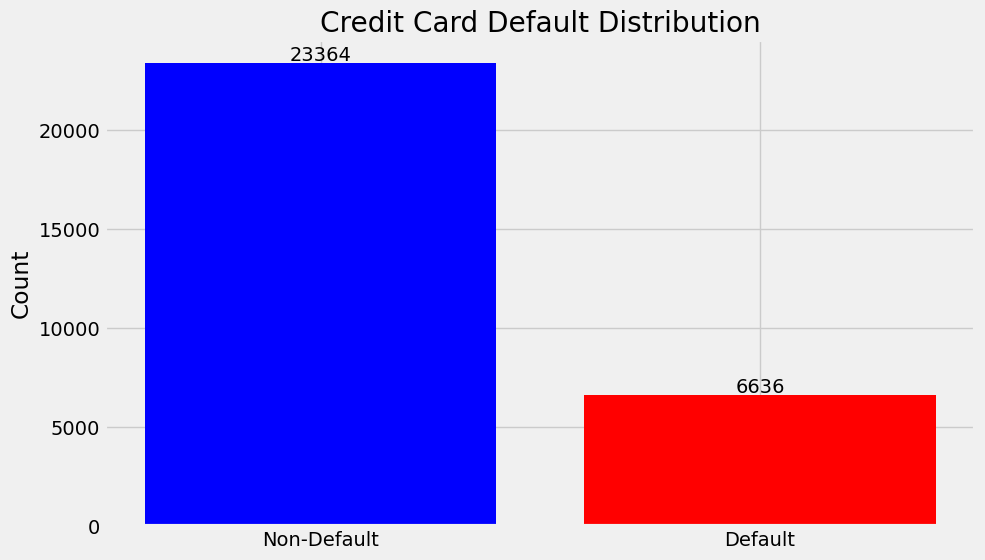

Default rate: 22.12%


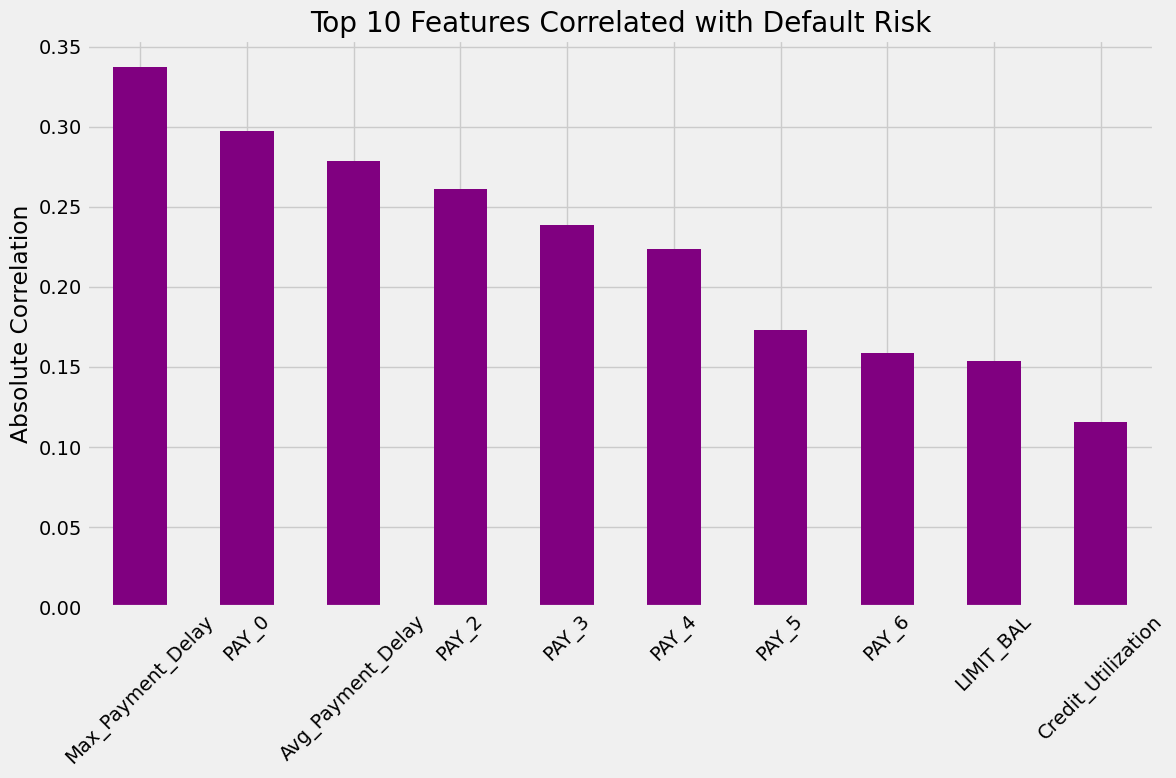

Top correlations with default:
  • Max_Payment_Delay: 0.3371
  • PAY_0: 0.2976
  • Avg_Payment_Delay: 0.2789
  • PAY_2: 0.2611
  • PAY_3: 0.2384


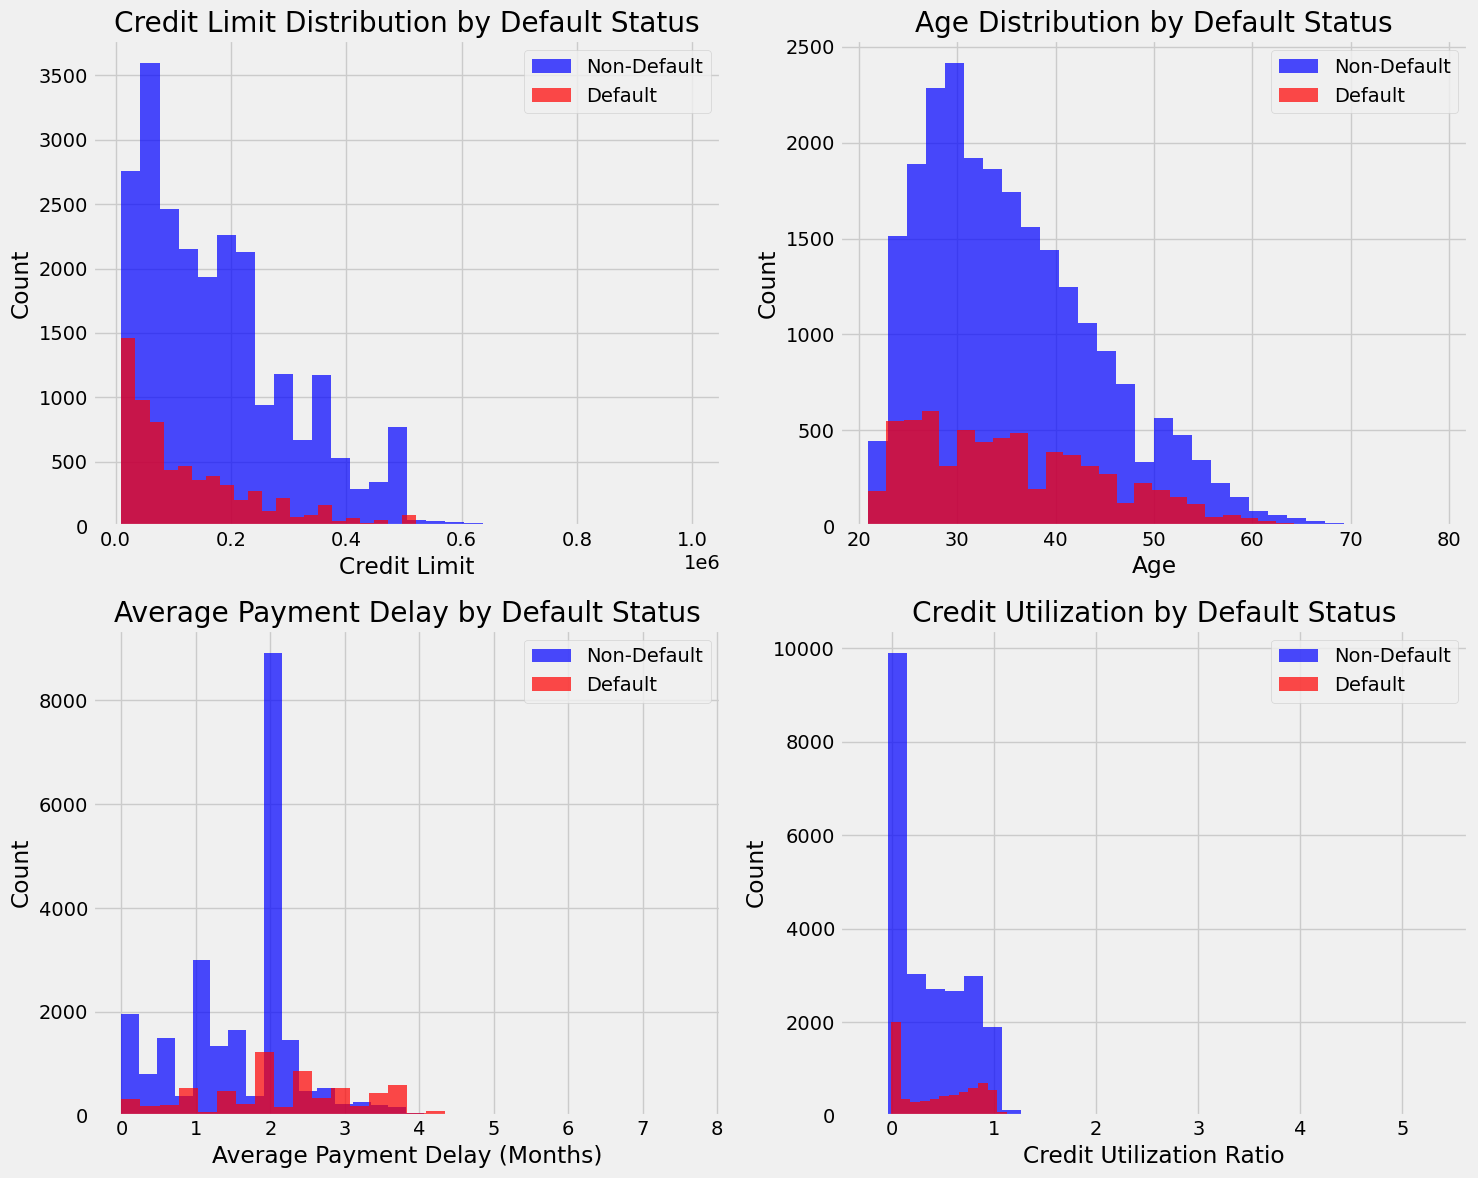

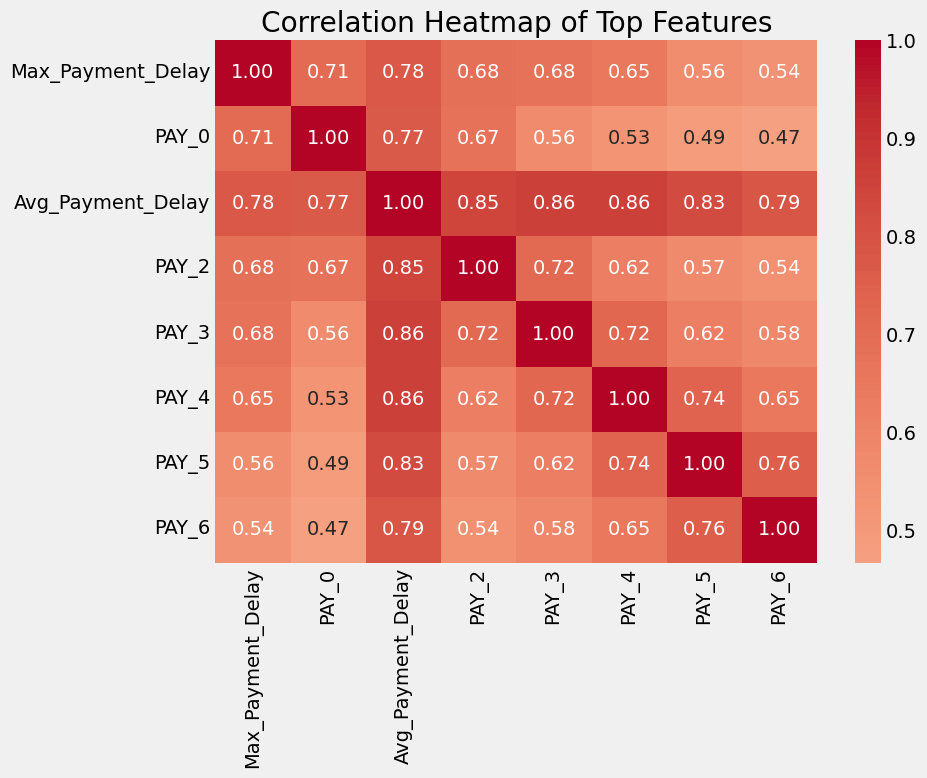

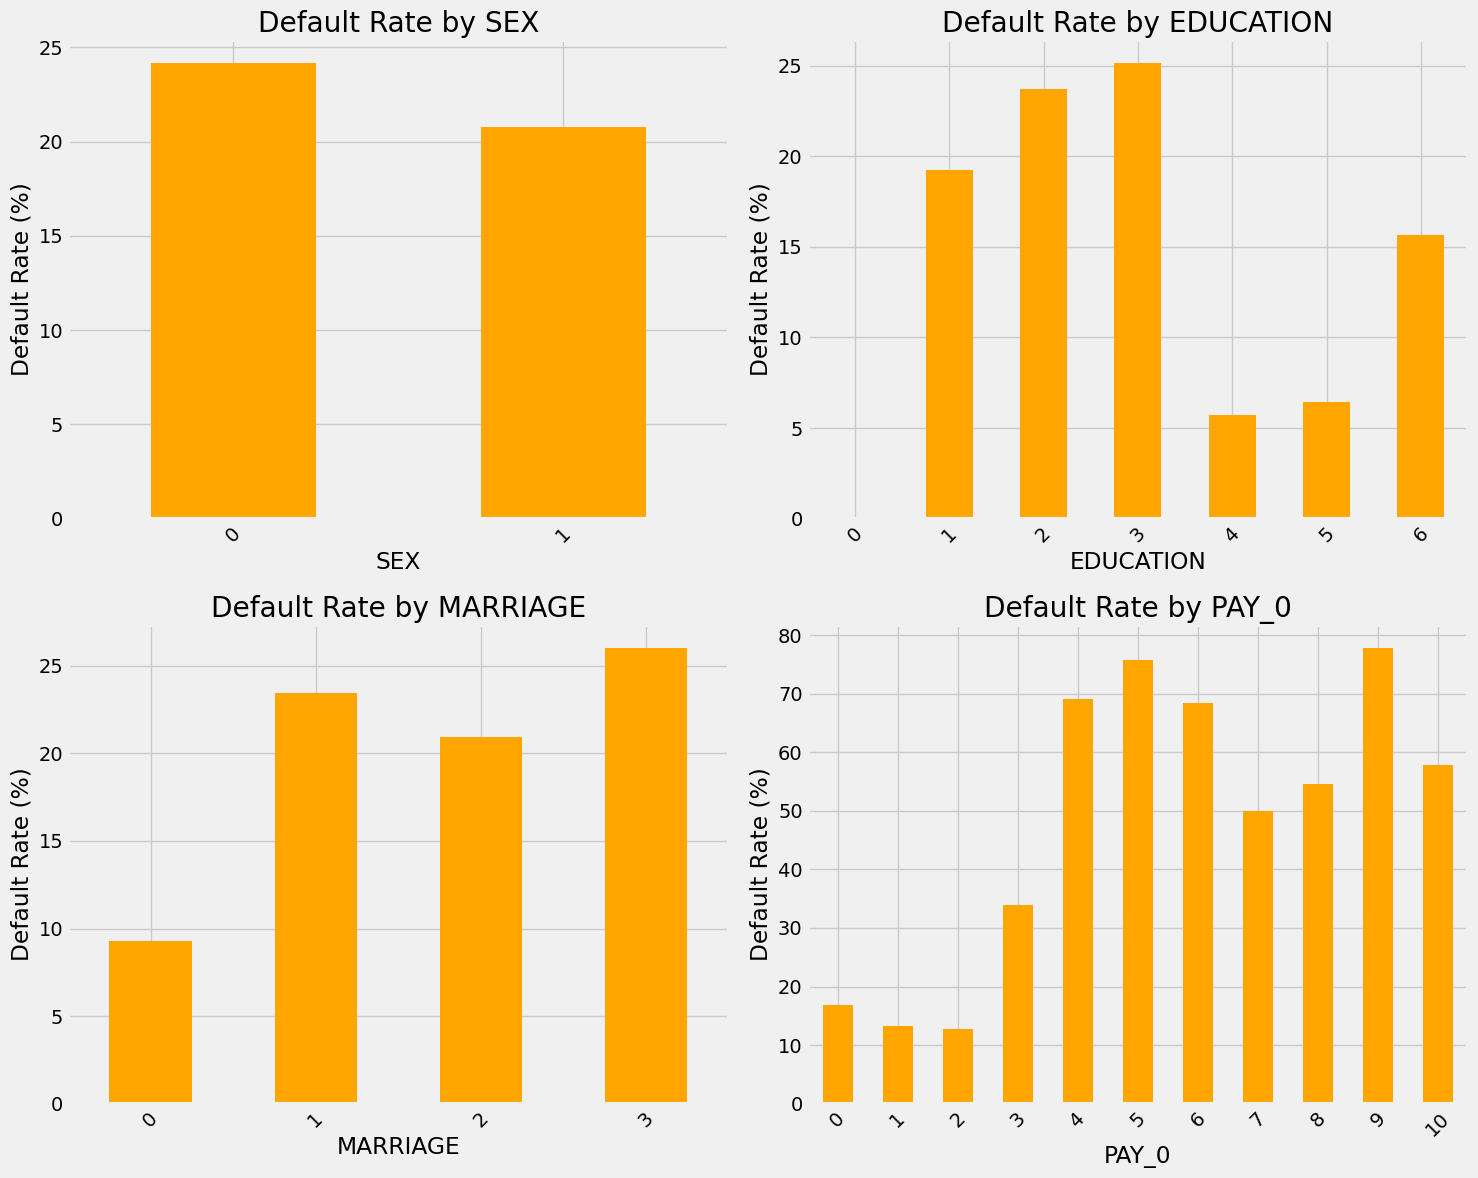

In [21]:
# Target distribution
plt.figure(figsize=(10, 6))
default_counts = y.value_counts()
plt.bar(['Non-Default', 'Default'], default_counts.values, color=['blue', 'red'])
plt.title('Credit Card Default Distribution')
plt.ylabel('Count')
for i, v in enumerate(default_counts.values):
    plt.text(i, v + 100, str(v), ha='center')
plt.show()

print(f"Default rate: {y.mean()*100:.2f}%")

correlations = X.corrwith(y).abs().sort_values(ascending=False)
top_correlations = correlations.head(10)

plt.figure(figsize=(12, 8))
top_correlations.plot(kind='bar', color='purple')
plt.title('Top 10 Features Correlated with Default Risk')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Top correlations with default:")
for feature, corr in top_correlations.head(5).items():
    print(f"  • {feature}: {corr:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# LIMIT_BAL
if 'LIMIT_BAL' in X.columns:
    axes[0, 0].hist(X[y == 0]['LIMIT_BAL'], bins=30, alpha=0.7, label='Non-Default', color='blue')
    axes[0, 0].hist(X[y == 1]['LIMIT_BAL'], bins=30, alpha=0.7, label='Default', color='red')
    axes[0, 0].set_title('Credit Limit Distribution by Default Status')
    axes[0, 0].set_xlabel('Credit Limit')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].legend()

# AGE
if 'AGE' in X.columns:
    axes[0, 1].hist(X[y == 0]['AGE'], bins=30, alpha=0.7, label='Non-Default', color='blue')
    axes[0, 1].hist(X[y == 1]['AGE'], bins=30, alpha=0.7, label='Default', color='red')
    axes[0, 1].set_title('Age Distribution by Default Status')
    axes[0, 1].set_xlabel('Age')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].legend()

# Payment Delay 
if 'Avg_Payment_Delay' in X.columns:
    axes[1, 0].hist(X[y == 0]['Avg_Payment_Delay'], bins=30, alpha=0.7, label='Non-Default', color='blue')
    axes[1, 0].hist(X[y == 1]['Avg_Payment_Delay'], bins=30, alpha=0.7, label='Default', color='red')
    axes[1, 0].set_title('Average Payment Delay by Default Status')
    axes[1, 0].set_xlabel('Average Payment Delay (Months)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].legend()

# Credit Utilization
if 'Credit_Utilization' in X.columns:
    axes[1, 1].hist(X[y == 0]['Credit_Utilization'], bins=30, alpha=0.7, label='Non-Default', color='blue')
    axes[1, 1].hist(X[y == 1]['Credit_Utilization'], bins=30, alpha=0.7, label='Default', color='red')
    axes[1, 1].set_title('Credit Utilization by Default Status')
    axes[1, 1].set_xlabel('Credit Utilization Ratio')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Correlation heatmap
top_features = top_correlations.index.tolist()[:8]
if len(top_features) > 1:
    plt.figure(figsize=(10, 8))
    corr_matrix = X[top_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Heatmap of Top Features')
    plt.tight_layout()
    plt.show()

# Categorical variable
if categorical_cols:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for i, col in enumerate(categorical_cols[:4]):
        default_rate = data.groupby(col)[target_col].mean() * 100
        default_rate.plot(kind='bar', ax=axes[i], color='orange')
        axes[i].set_title(f'Default Rate by {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Default Rate (%)')
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

In [22]:
print(f"Class distribution: {y.value_counts()}")
print(f"Default rate: {y.mean():.4f}")

print(f"Missing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")

X = X.fillna(0)

## fix
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        col_max = X[col].max()
        col_min = X[col].min()
        if col_max > 1e10 or col_min < -1e10:
            print(f"Column {col} has extreme values: min={col_min}, max={col_max}")
            upper_limit = X[col].quantile(0.999)
            lower_limit = X[col].quantile(0.001)
            X[col] = np.clip(X[col], lower_limit, upper_limit)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Class distribution after SMOTE: {pd.Series(y_train_resampled).value_counts()}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=(len(y_train_resampled) - sum(y_train_resampled)) / sum(y_train_resampled))
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")

    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train_resampled)
    else:
        model.fit(X_train_resampled, y_train_resampled)

    if name == 'Logistic Regression':
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] for m in results],
    'Avg Precision': [results[m]['avg_precision'] for m in results]
})

print("\nModel Performance Comparison:")
print(comparison_df.round(4))

Class distribution: default payment next month
0    23364
1     6636
Name: count, dtype: int64
Default rate: 0.2212
Missing values in X: 8
Missing values in y: 0
Column Bill_to_Payment_Ratio has extreme values: min=-10883.25, max=inf
Train shape: (24000, 32), Test shape: (6000, 32)
Class distribution after SMOTE: default payment next month
0    18691
1    18691
Name: count, dtype: int64
Training Logistic Regression...
Logistic Regression - Accuracy: 0.8073, Precision: 0.6209, Recall: 0.3308, F1: 0.4317, ROC-AUC: 0.7216
Training Random Forest...
Random Forest - Accuracy: 0.8010, Precision: 0.5620, Recall: 0.4544, F1: 0.5025, ROC-AUC: 0.7520
Training XGBoost...
XGBoost - Accuracy: 0.7997, Precision: 0.5618, Recall: 0.4280, F1: 0.4859, ROC-AUC: 0.7563

Model Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  \
0  Logistic Regression    0.8073     0.6209  0.3308    0.4317   0.7216   
1        Random Forest    0.8010     0.5620  0.4544    0.5025 

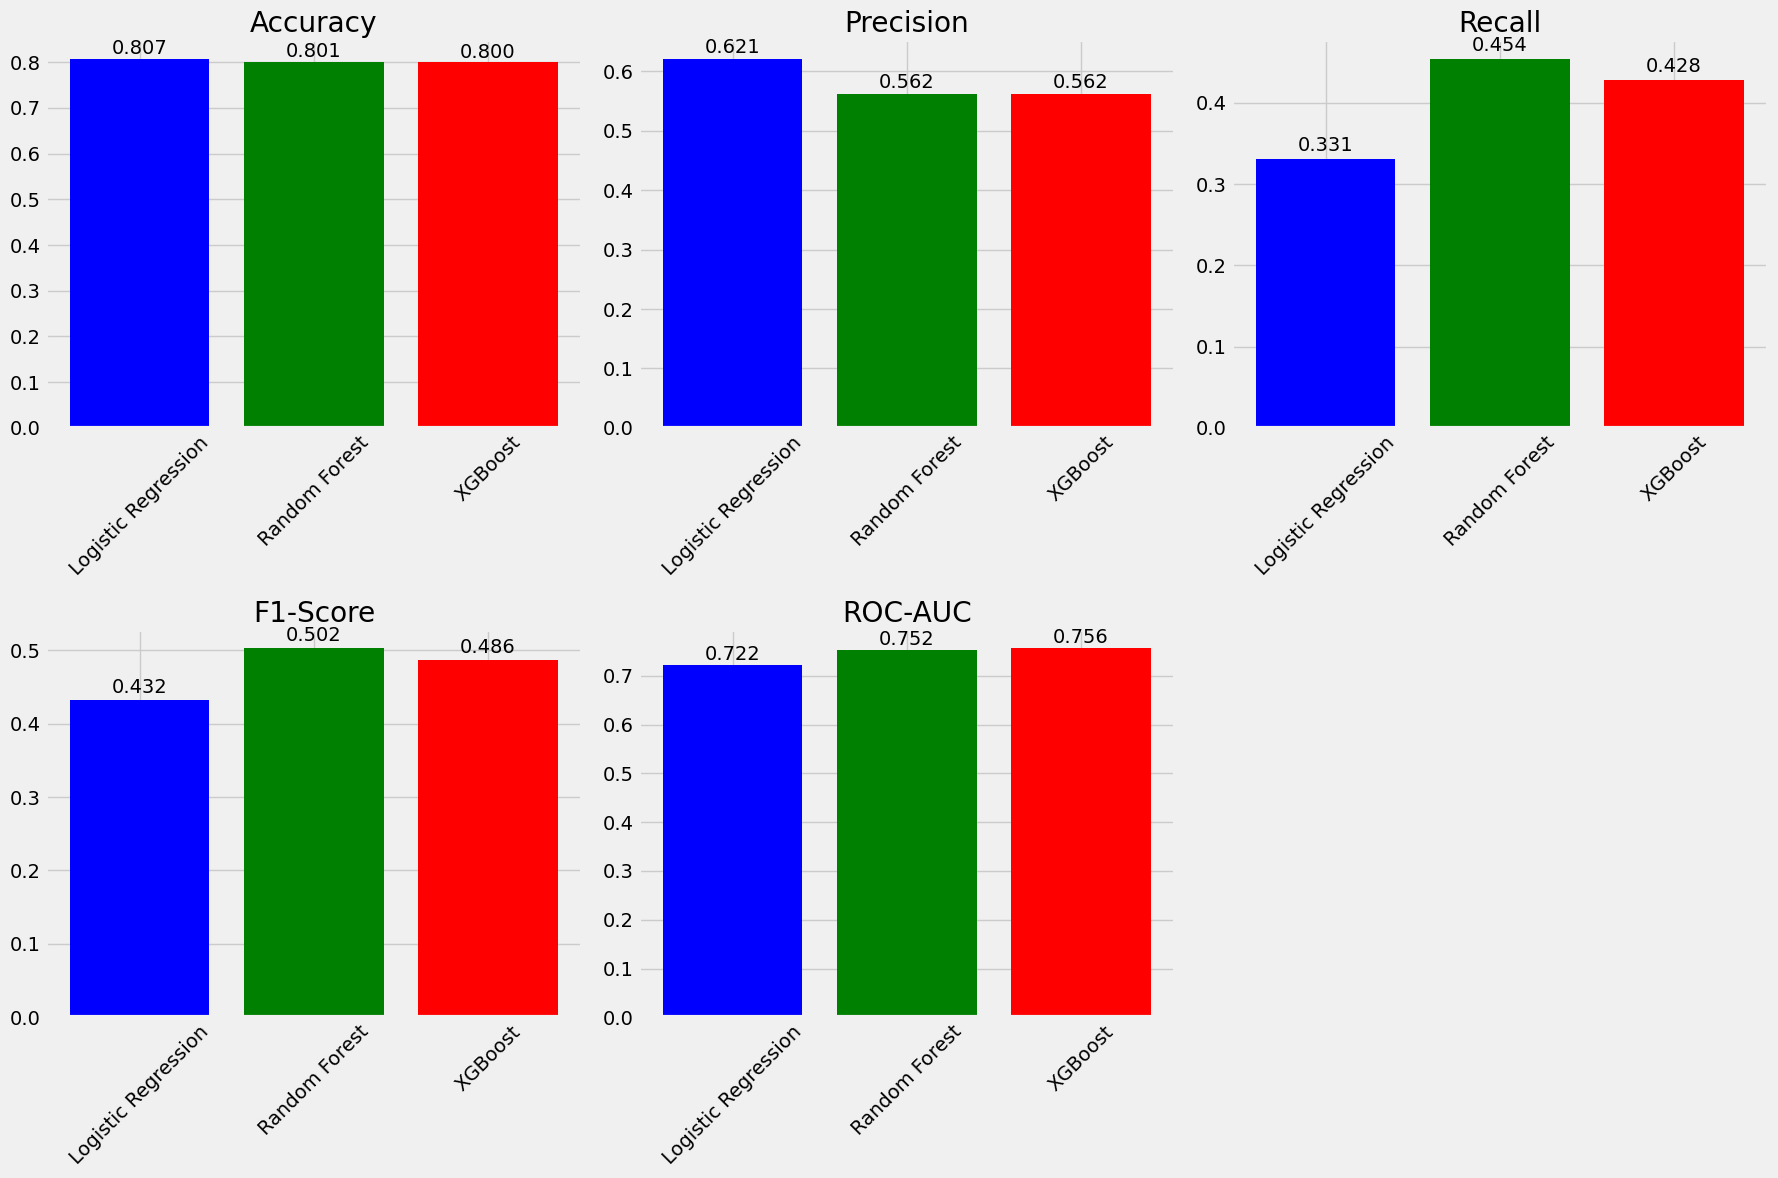

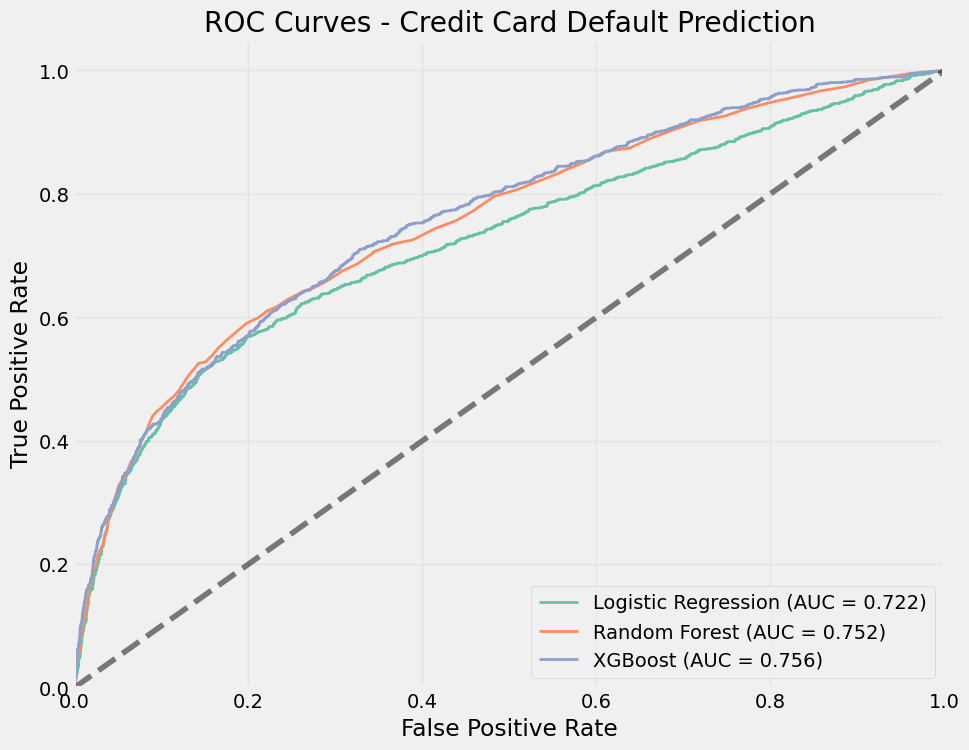

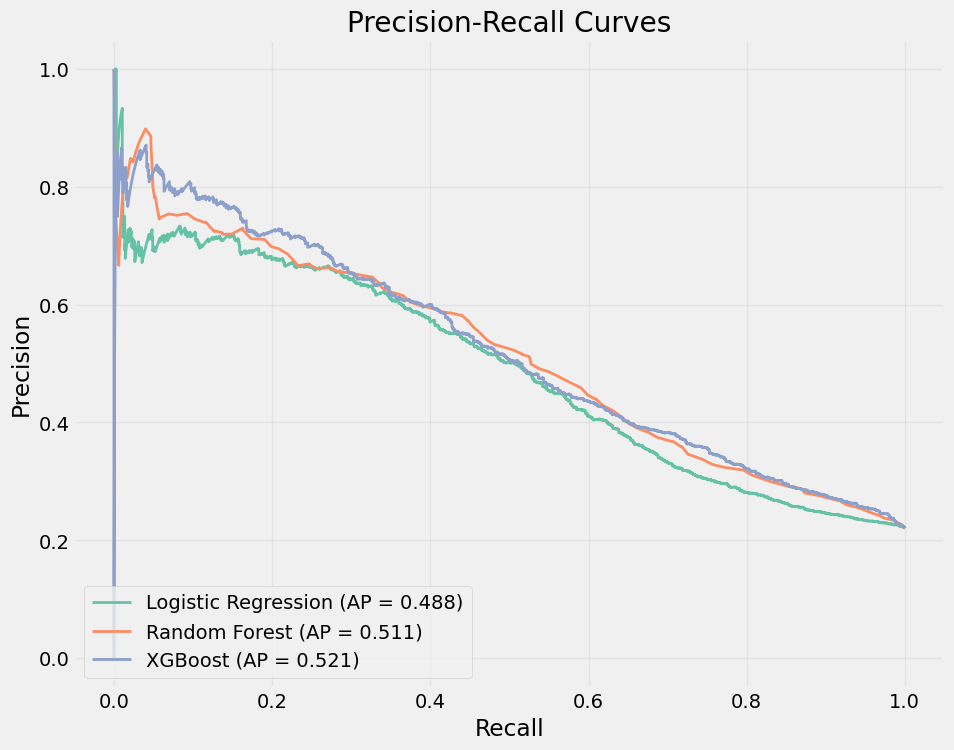

BEST PERFORMING MODEL: Random Forest


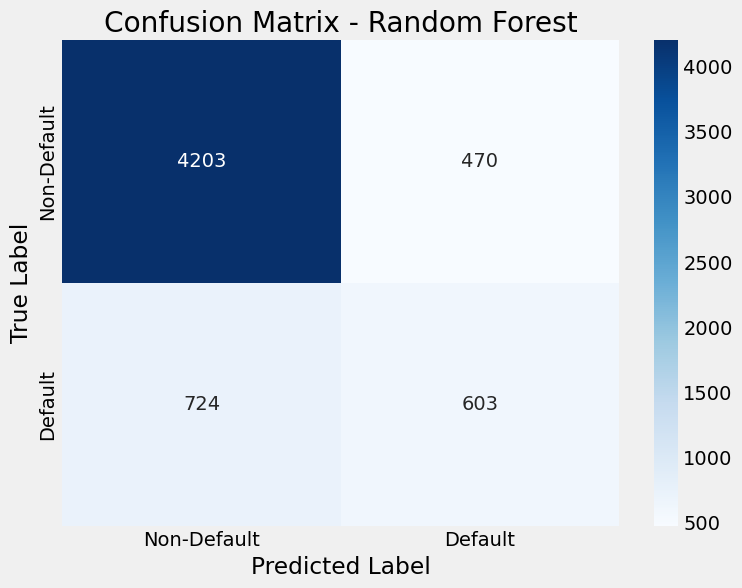


Classification Report - Random Forest:
              precision    recall  f1-score   support

 Non-Default       0.85      0.90      0.88      4673
     Default       0.56      0.45      0.50      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.68      0.69      6000
weighted avg       0.79      0.80      0.79      6000



In [23]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

metric_mapping = {
    'Accuracy': 'accuracy',
    'Precision': 'precision', 
    'Recall': 'recall',
    'F1-Score': 'f1',
    'ROC-AUC': 'roc_auc'
}

for i, metric in enumerate(metrics):
    values = [results[m][metric_mapping[metric]] for m in results]
    axes[i].bar(results.keys(), values, color=['blue', 'green', 'red'])
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
    
    for j, v in enumerate(values):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center')

if len(metrics) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Credit Card Default Prediction')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 8))
for name, result in results.items():
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, result['y_pred_proba'])
    avg_precision = average_precision_score(y_test, result['y_pred_proba'])
    plt.plot(recall_vals, precision_vals, label=f'{name} (AP = {avg_precision:.3f})', linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['y_pred']

print(f"BEST PERFORMING MODEL: {best_model_name}")

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Default', 'Default'], 
            yticklabels=['Non-Default', 'Default'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nClassification Report - {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=['Non-Default', 'Default']))